In [239]:
##%pip install kagglehub
#%pip uninstall -y tensorflow tensorflow-cpu tensorflow-gpu keras-ocr numpy protobuf
#%pip cache purge
#
#%pip install "numpy<2" --upgrade
#
## Install specific versions with --no-deps to prevent auto-upgrades
#%pip install tensorflow==2.10.0
#%pip install keras-ocr==0.8.9
#%pip install tensorflow-gpu==2.10.0 --no-deps
#%pip install tensorflow-cpu==2.10.0 --no-deps
#%pip install tensorflow==2.10.0 --no-deps
#%pip install protobuf==3.20.3 --no-deps
#%pip install python-Levenshtein
#%pip install pytesseract
#%pip install easyocr
#%pip install git+https://github.com/faustomorales/keras-ocr.git@v0.8.9
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
print("Numpy version:", pd.__version__)

Numpy version: 1.4.2


In [2]:
# Example
file_path = "written_name_test_v2.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "landlord/handwriting-recognition",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

C:\Users\adam4\AppData\Local\Temp\ipykernel_15200\2912609907.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:         FILENAME  IDENTITY
0  TEST_0001.jpg     KEVIN
1  TEST_0002.jpg  CLOTAIRE
2  TEST_0003.jpg      LENA
3  TEST_0004.jpg     JULES
4  TEST_0005.jpg   CHERPIN


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("landlord/handwriting-recognition")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\adam4\.cache\kagglehub\datasets\landlord\handwriting-recognition\versions\1


In [171]:
train = pd.read_csv('1/written_name_train_v2.csv')
valid = pd.read_csv('1/written_name_validation_v2.csv')
test = pd.read_csv('1/written_name_test_v2.csv')
test

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN
...,...,...
41365,TEST_41366.jpg,ALEXANE
41366,TEST_41367.jpg,PEREIRA-SILVA
41367,TEST_41368.jpg,LAURENT
41368,TEST_41369.jpg,DEFFENSE


In [172]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())
print("Number of NaNs in test set : ", test['IDENTITY'].isnull().sum())

train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())
print("Number of NaNs in test set : ", test['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78
Number of NaNs in test set :  70
Number of NaNs in train set      :  0
Number of NaNs in validation set :  0
Number of NaNs in test set :  0


In [6]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

In [173]:
train = train[train["IDENTITY"] != 'UNREADABLE']
valid = valid[valid["IDENTITY"] != "UNREADABLE"]
test = test[test["IDENTITY"] != "UNREADABLE"]
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
test['IDENTITY'] = test['IDENTITY'].str.upper()
train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

C:\Users\adam4\AppData\Local\Temp\ipykernel_15200\2570346784.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['IDENTITY'] = test['IDENTITY'].str.upper()


In [174]:
test

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN
...,...,...
41284,TEST_41366.jpg,ALEXANE
41285,TEST_41367.jpg,PEREIRA-SILVA
41286,TEST_41368.jpg,LAURENT
41287,TEST_41369.jpg,DEFFENSE


In [175]:
import os
from difflib import SequenceMatcher
import Levenshtein
import cv2
import time
import numpy as np

# Directories
expected_output_directory = 'cleaned/000'
actual_output_directory = 'outputs/py_cleaned'
trainSize = 25000
validateSize = 2500

#width =256 and height= 64
def cleanImage(img):
    (h,w) = img.shape
    final = np.ones([64,256])*255 #blank
    if w>256:
         img = img[:,:256]     #MAYBE TRY RESIZE HERE
    if h>64:
        img=img[:64, :]

    final[:h, :w]=img
    final = cv2.rotate(final,cv2.ROTATE_90_CLOCKWISE)
    return final

def cleanTextFile(text):
    return text.replace('\n', ' ')
    
# METHOD 1:
# Similarity percentage using Levenshtein distance (edit distance), more robust for OCR
# Levenshtein distance outputs how similar, not dis-similar
def calculate_similarity_lev(text1, text2):
    text1 = cleanTextFile(text1)
    text2 = cleanTextFile(text2)
    print(f"Text1: {text1}")
    print(f"Text2: {text2}")
    
    distance = Levenshtein.distance(text1, text2)
    max_length = max(len(text1), len(text2))
    if max_length == 0:  # Avoids dividing by zero
        return 100.0
    return (1 - distance / max_length) * 100

def openCalculate(path):
    result = ''
    if os.path.exists(path):
                with open(path, 'r') as f:
                    result = f.read()
    return result

def prepTrainValid(type, size):
    for i in range(size):
        path =''
        if type == "train":
            path = "1/train_v2/train/"+train.loc[i, "FILENAME"]
        elif type =="validation":
            path = "1/validation_v2/validation/"+valid.loc[i, "FILENAME"]
        else:
             print("Wrong type")
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cleanImage(img)
        img = img/255 #Normalization
        return np.array(img).reshape(-1,256,64,1)


In [176]:
def loadDataAll(groundTruthDir, pyTesseractOutputTyped, pyTesseractOutputWritten, 
                kerasOCROutputTyped, kerasOCROutputWritten, easyOCROutputTyped, easyOCROutputWritten):
    count = 0
    pyTesseractTypedScore = 0
    pyTesseractWrittenScore = 0
    kerasOCRTypedScore = 0
    kerasOCRWrittenScore = 0
    easyOCRTypedScore = 0
    easyOCRWrittenScore = 0

    for filename in os.listdir(groundTruthDir):
        if filename.endswith('.txt'):
            # Construct file paths
            groundTruthPath = os.path.join(groundTruthDir, filename)
            pyTesseractTypedPath = os.path.join(pyTesseractOutputTyped, filename)
            pyTesseractWrittenPath = os.path.join(pyTesseractOutputWritten, filename)
            kerasOCRTypedPath = os.path.join(kerasOCROutputTyped, filename)
            kerasOCRWrittenPath = os.path.join(kerasOCROutputWritten, filename)
            easyOCRTypedPath = os.path.join(easyOCROutputTyped, filename)
            easyOCRWrittenPath = os.path.join(easyOCROutputWritten, filename)
    
            # Read file contents
            groundTruthText = openCalculate(groundTruthPath)
            pyTesseractTypedText = openCalculate(pyTesseractTypedPath)
            pyTesseractWrittenText = openCalculate(pyTesseractWrittenPath)
            kerasOCRTypedText = openCalculate(kerasOCRTypedPath)
            kerasOCRWrittenText = openCalculate(kerasOCRWrittenPath)
            easyOCRTypedText = openCalculate(easyOCRTypedPath)
            easyOCRWrittenText = openCalculate(easyOCRWrittenPath)

            # Calculate similarities
            pyTesseractTypedScoreLev = calculate_similarity_lev(pyTesseractTypedText, groundTruthText)
            pyTesseractWrittenScoreLev = calculate_similarity_lev(pyTesseractWrittenText, groundTruthText)
            kerasOCRTypedScoreLev = calculate_similarity_lev(kerasOCRTypedText, groundTruthText)
            kerasOCRWrittenScoreLev = calculate_similarity_lev(kerasOCRWrittenText, groundTruthText)
            easyOCRTypedScoreLev = calculate_similarity_lev(easyOCRTypedText, groundTruthText)
            easyOCRWrittenScoreLev = calculate_similarity_lev(easyOCRWrittenText, groundTruthText)
            
            print(f"File: {filename}")
            print(f"Similarity Percentage from Levenshtein with PyTesseract Typed: {pyTesseractTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with PyTesseract Written: {pyTesseractWrittenScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Keras OCR Typed: {kerasOCRTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Keras OCR Written: {kerasOCRWrittenScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Easy OCR Typed: {easyOCRTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Easy OCR Written: {easyOCRWrittenScoreLev:.2f}%")
            
            # Accumulate scores
            count += 1
            pyTesseractTypedScore += pyTesseractTypedScoreLev
            pyTesseractWrittenScore += pyTesseractWrittenScoreLev
            kerasOCRTypedScore += kerasOCRTypedScoreLev
            kerasOCRWrittenScore += kerasOCRWrittenScoreLev
            easyOCRTypedScore += easyOCRTypedScoreLev
            easyOCRWrittenScore += easyOCRWrittenScoreLev            
        else:
            print(f"Expected output not found for {filename}")

    # Calculate averages and return results
    if count > 0:
        result = {
            "pytesseract Typed": pyTesseractTypedScore / count,
            "pytesseract Written": pyTesseractWrittenScore / count,
            "kerasOCR Typed": kerasOCRTypedScore / count,
            "kerasOCR Written": kerasOCRWrittenScore / count,
            "easyOCR Typed": easyOCRTypedScore / count,
            "easyOCR Written": easyOCRWrittenScore / count
        }
        return result
    else:
        return None

# Pytesseract

In [11]:
import pytesseract
from PIL import Image
import os

#Tesseract executable
pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract.exe"

imageWritten = 'cleaned/000-written'
imageTyped = 'cleaned/000-typed'
imageNameWritten = '1/test_v2/test'

def processImagesPyTesseract(imageDirectory, outputDirectory, process):
    pyTesseractTimes = {}
    counter = 0
    for filename in os.listdir(imageDirectory):
        print(filename)
        if counter == 200:
            break
        if filename.endswith('.png') or filename.endswith('jpg'):
            image_path = os.path.join(imageDirectory, filename)

            # Open using PIL (Need to open with RGB and not BGR)
            img = Image.open(image_path)
            if process:
                img = cleanImage(img, "tesseract") 

            # Output file format
            output_file =outputDirectory + os.path.splitext(filename)[0] + '.txt'

            # Run Tesseract and writes into output file
            with open(output_file, 'w') as f:
                startTime = time.time()
                text = pytesseract.image_to_string(img, config="--oem 3 --psm 6") #better for written notes (oem 3 is best OCR engine [LSTM + Legacy], psm 6 assumes block text) 
                endTime = time.time()
                pyTesseractTimes[filename] = endTime - startTime
                f.write(text)

            print(f"Text extracted from {filename} and saved to {output_file}")
        counter += 1
    return pyTesseractTimes
#Uncomment to run PyTesseract on images
#print("Processing images in directory (PyTesseract):", imageWritten)
#pyTesseractWrittenTime= processImagesPyTesseract(imageWritten, "pyWritten", False)
#print("\nProcessing images in directory  (PyTesseract):", imageTyped)
#pyTesseractTypedTime=processImagesPyTesseract(imageTyped, "pyTyped", False)
temp = processImagesPyTesseract(imageNameWritten, "output-name/pytesseract/", False)


TEST_0001.jpg
Text extracted from TEST_0001.jpg and saved to output-name/pytesseract/TEST_0001.txt
TEST_0002.jpg
Text extracted from TEST_0002.jpg and saved to output-name/pytesseract/TEST_0002.txt
TEST_0003.jpg
Text extracted from TEST_0003.jpg and saved to output-name/pytesseract/TEST_0003.txt
TEST_0004.jpg
Text extracted from TEST_0004.jpg and saved to output-name/pytesseract/TEST_0004.txt
TEST_0005.jpg
Text extracted from TEST_0005.jpg and saved to output-name/pytesseract/TEST_0005.txt
TEST_0006.jpg
Text extracted from TEST_0006.jpg and saved to output-name/pytesseract/TEST_0006.txt
TEST_0007.jpg
Text extracted from TEST_0007.jpg and saved to output-name/pytesseract/TEST_0007.txt
TEST_0008.jpg
Text extracted from TEST_0008.jpg and saved to output-name/pytesseract/TEST_0008.txt
TEST_0009.jpg
Text extracted from TEST_0009.jpg and saved to output-name/pytesseract/TEST_0009.txt
TEST_0010.jpg
Text extracted from TEST_0010.jpg and saved to output-name/pytesseract/TEST_0010.txt
TEST_0011.

Keras OCR

In [ ]:
import os
import keras_ocr
import numpy as np
from PIL import Image
from typing import List

def processImagesKerasOcr(imageDirectory, outputDirectory):
    pipeline = keras_ocr.pipeline.Pipeline()
    
    # Get all image files from the folder
    imagePaths = []
    validExtensions = ('.jpg',  '.png', )
    
    counter = 0
    for filename in os.listdir(imageDirectory):
        if counter == 200:
            break
        if filename.lower().endswith(validExtensions):
            print("Testing image: ", filename)
            imagePaths.append(os.path.join(imageDirectory, filename))
        counter += 1
    if not imagePaths:
        return
    
    images = [keras_ocr.tools.read(img_path) for img_path in imagePaths]
    prediction_groups = pipeline.recognize(images)
    
    results = []
    for predictions in prediction_groups:
        text = ' '.join([prediction[0] for prediction in predictions])
        results.append(text)

    for filename, predictions in zip(imagePaths, prediction_groups):
        text = ' '.join([prediction[0] for prediction in predictions])
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_filepath = os.path.join(outputDirectory, txt_filename.split("\\")[-1])
        with open(txt_filepath, "w", encoding="utf-8") as txt_file:
            print("Writting into: ", txt_filepath)
            txt_file.write(text)
            txt_file.write(text)
    return #NEED TO ADD RESULT

# Example usage:
processImagesKerasOcr(imageNameWritten,'output-name/keras')


Looking for C:\Users\adam4\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\adam4\.keras-ocr\crnn_kurapan.h5
Testing image:  TEST_0001.jpg
Testing image:  TEST_0002.jpg
Testing image:  TEST_0003.jpg
Testing image:  TEST_0004.jpg
Testing image:  TEST_0005.jpg
Testing image:  TEST_0006.jpg
Testing image:  TEST_0007.jpg
Testing image:  TEST_0008.jpg
Testing image:  TEST_0009.jpg
Testing image:  TEST_0010.jpg
Testing image:  TEST_0011.jpg
Testing image:  TEST_0012.jpg
Testing image:  TEST_0013.jpg
Testing image:  TEST_0014.jpg
Testing image:  TEST_0015.jpg
Testing image:  TEST_0016.jpg
Testing image:  TEST_0017.jpg
Testing image:  TEST_0018.jpg
Testing image:  TEST_0019.jpg
Testing image:  TEST_0020.jpg
Testing image:  TEST_0021.jpg
Testing image:  TEST_0022.jpg
Testing image:  TEST_0023.jpg
Testing image:  TEST_0024.jpg
Testing image:  TEST_0025.jpg
Testing image:  TEST_0026.jpg
Testing image:  TEST_0027.jpg
Testing image:  TEST_0028.jpg
Testing image:  TEST_0029.jpg
Testing image:  TEST_

In [ ]:
characterLabels = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-',. "
lenCharacterLabels = len(characterLabels) + 1
maxLen = 32 #NEED TO FIGOURE OUT                WAS 0 BEFORE IDK IF IT IS CORRECT
num_of_timestamps = 64
def labelNumber(label):
    num = []
    for i in label:
        num.append(characterLabels.find(i))
    return np.array(num)

def numberLabel(num):
    label =""
    for i in num:
        if i ==-1:
            break
        else:
            label += characterLabels[i]
    return label

#def  nnumberLabel

In [ ]:
# BEFLOW IS DIFFERENT PAGE
train_y = np.ones([trainSize, maxLen]) * -1
train_label_len = np.zeros([trainSize, 1])
train_input_len = np.ones([trainSize, 1]) * (num_of_timestamps-2)
train_output = np.zeros([trainSize])

for i in range(trainSize):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= labelNumber(train.loc[i, 'IDENTITY'])

valid_y = np.ones([validateSize, maxLen]) * -1
valid_label_len = np.zeros([validateSize, 1])
valid_input_len = np.ones([validateSize, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([validateSize])

for i in range(validateSize):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= labelNumber(valid.loc[i, 'IDENTITY'])  
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.models import Model

input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

#CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(lenCharacterLabels, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization_3 (Batc  (None, 256, 64, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                          

In [ ]:
from keras.layers import Lambda

# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

labels = Input(name='gtruth_labels', shape=[maxLen], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [ ]:
from keras.optimizers import Adam

model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[prepTrainValid('train', trainSize), train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([prepTrainValid('validation', validateSize), valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

c:\Users\adam4\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


ValueError: Data cardinality is ambiguous:
  x sizes: 1, 25000, 25000, 25000
  y sizes: 25000
Make sure all arrays contain the same number of samples.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from keras.layers import Activation

# Define model architecture
def build_model(img_shape=(256, 64, 1), maxLen=32):
    inputs = Input(shape=img_shape, name="image_input")


    #INSPO FROM GOOGLE COLLAB
    # CNN Feature Extractor
    x = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    # Reshape for RNN
    x = Reshape(target_shape=(32, -1))(x)

    # RNN Encoder
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)

    # Output layer
    x = Dense(64, activation="softmax", name="output")(x)
    outputs = Activation('softmax', name='softmax')(x)

    model = Model(inputs, outputs)
    return model, outputs

# Build model
model = build_model()
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 256, 64, 1)]      0         
                                                                 
 conv2d_18 (Conv2D)          (None, 256, 64, 64)       640       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 128, 32, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 32, 128)      73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 64, 16, 128)      0         
 g2D)                                                            
                                                                 
 reshape_8 (Reshape)         (None, 32, 4096)          0  

[(0, 0), (388, 0), (388, 20), (0, 20)]


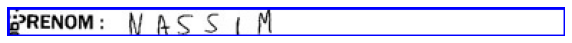

(20, 388, 3)


In [12]:
import cv2
import matplotlib.pyplot as plt

def getBoundingBox(image_path):
    image = cv2.imread(image_path)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Get word-level bounding boxes
    data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)

    allBox = []
    x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0

    # Loop through detected words
    for i in range(len(data['text'])):
        if data['text'][i].strip():  # Ignore empty text
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            
            # Compute full bounding box limits
            x_min = min(x_min, x)
            y_min = min(y_min, y)
            x_max = max(x_max, x + w)
            y_max = max(y_max, y + h)
            # Store individual word bounding box
            #temp = [(x, y), (x + w, y), (x + w, y + h), (x, y + h)]
            #allBox.append(temp)

            # Draw individual word bounding box
            #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            #cv2.putText(image, data['text'][i], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
    #Use whole image to avoid inf (data already cleaned)
    if x_min == float('inf') or y_min == float('inf'):
        #    print("No text detected! Using full image as bounding box.")
            x_min, y_min = 0, 0
            y_max, x_max = image.shape[:2]  # height, width
    full_bbox = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]
    
    # Draw single full bounding box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

    return image, allBox, full_bbox


image, boxes, full_bbox= getBoundingBox("1/train_v2/train/TRAIN_00007.jpg")
print(full_bbox)
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()
print(image.shape)


In [177]:
def get_dataset_from_df(df, image_folder, limit):
    dataset = []
    i = 0
    for _, row in df.iterrows():
        if limit == i :
            break
        image_name = row['FILENAME']  # Assuming the column is named 'filename'
        text = row['IDENTITY']  # Assuming the column is named 'text'
        
        # Construct the full image path
        image_path = image_folder+"/"+ image_name
        print(image_path)
        img, allBBox, BBox =getBoundingBox(image_path)
        dataset.append((image_path, {"lines": [{"text": text, "vertices": BBox}]}))
        i += 1
    return dataset

train_dataset = get_dataset_from_df(train, '1/train_v2/train', 2)
val_dataset = get_dataset_from_df(valid, '1/validation_v2/validation', 1)
test_dataset = get_dataset_from_df(test, '1/test_v2/test', 1)

1/train_v2/train/TRAIN_00001.jpg
1/train_v2/train/TRAIN_00002.jpg
1/validation_v2/validation/VALIDATION_0001.jpg
1/test_v2/test/TEST_0001.jpg


In [178]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

[('1/train_v2/train/TRAIN_00001.jpg', {'lines': [{'text': 'BALTHAZAR', 'vertices': [(30, 10), (163, 10), (163, 43), (30, 43)]}]}), ('1/train_v2/train/TRAIN_00002.jpg', {'lines': [{'text': 'SIMON', 'vertices': [(30, 5), (104, 5), (104, 56), (30, 56)]}]})]
[('1/validation_v2/validation/VALIDATION_0001.jpg', {'lines': [{'text': 'BILEL', 'vertices': [(22, 7), (94, 7), (94, 22), (22, 22)]}]})]
[('1/test_v2/test/TEST_0001.jpg', {'lines': [{'text': 'KEVIN', 'vertices': [(25, 6), (91, 6), (91, 22), (25, 22)]}]})]


In [15]:
# In Jupyter/Colab:%pip uninstall -y keras-ocr
#%pip install keras-ocr==0.8.9
import keras_ocr
print(keras_ocr.__version__)
print(keras_ocr.__file__)  # This reveals the problematic path

0.8.9
c:\Users\adam4\anaconda3\lib\site-packages\keras_ocr\__init__.py


In [204]:
import os
import pandas as pd

def create_keras_ocr_dataset(image_dir, df, limit, image_col='FILENAME', text_col='IDENTITY'):
    """
    Create a keras-ocr dataset from a directory of images and a DataFrame.
    
    Args:
        image_dir (str): Path to directory containing images
        df (pd.DataFrame): DataFrame containing image filenames and corresponding text
        image_col (str): Column name in df containing image filenames
        text_col (str): Column name in df containing text labels
    
    Returns:
        list: List of tuples in format [(image_path, text), ...]
    """
    dataset = []
    count = 0
    for _, row in df.iterrows():
        if count == limit:
            break
        image_path = image_dir+"/"+ row[image_col]
        if os.path.exists(image_path):
            dataset.append((image_path, row[text_col]))
        else:
            print(f"Warning: Image not found at {image_path}")
        count +=1
    return dataset

train_dataset = create_keras_ocr_dataset( '1/train_v2/train',train, 800)
validation_dataset = create_keras_ocr_dataset( '1/validation_v2/validation',valid, 200)
test_datasset = create_keras_ocr_dataset('1/test_v2/test', test, 50)
print(train_dataset)
print(validation_dataset)
print(test_datasset)

import tensorflow as tf
def loadTrainData(dataSetList, imageSize=(200, 31)):
    images = []
    texts = []
    for (path,text)in dataSetList:
        img = cv2.imread(path)  # Load image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert BGR to RGB
        #COULD RESIZE
        img = cv2.resize(img, imageSize)#MAYBE ROTATE IMAGE AND THEN HAVE LENGTH AND WIDTH FLIPPED

        img = img/255.0
        #img = img.astype(np.float32) / 255.0  # Normalize pixel values to [0,1]
        #img = tf.convert_to_tensor(img, dtype=tf.float32)  # Convert to TensorFlow tensor
        images.append(img)
        texts.append(text)
    return np.array(images), texts

[('1/train_v2/train/TRAIN_00001.jpg', 'BALTHAZAR'), ('1/train_v2/train/TRAIN_00002.jpg', 'SIMON'), ('1/train_v2/train/TRAIN_00003.jpg', 'BENES'), ('1/train_v2/train/TRAIN_00004.jpg', 'LA LOVE'), ('1/train_v2/train/TRAIN_00005.jpg', 'DAPHNE'), ('1/train_v2/train/TRAIN_00006.jpg', 'LUCIE'), ('1/train_v2/train/TRAIN_00007.jpg', 'NASSIM'), ('1/train_v2/train/TRAIN_00008.jpg', 'ASSRAOUI'), ('1/train_v2/train/TRAIN_00009.jpg', 'LAVIAN'), ('1/train_v2/train/TRAIN_00010.jpg', 'MAEVA'), ('1/train_v2/train/TRAIN_00011.jpg', 'EMMA'), ('1/train_v2/train/TRAIN_00012.jpg', 'MOULINIER'), ('1/train_v2/train/TRAIN_00013.jpg', 'ELISE'), ('1/train_v2/train/TRAIN_00014.jpg', 'HONNERT'), ('1/train_v2/train/TRAIN_00015.jpg', 'MATHEO'), ('1/train_v2/train/TRAIN_00016.jpg', 'PETITDIDIER'), ('1/train_v2/train/TRAIN_00017.jpg', 'PAULINE'), ('1/train_v2/train/TRAIN_00018.jpg', 'LOUVENAZ'), ('1/train_v2/train/TRAIN_00019.jpg', 'BOURQUIN'), ('1/train_v2/train/TRAIN_00020.jpg', 'ROMAIN'), ('1/train_v2/train/TRAIN_0

In [236]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# CTC loss function
def ctc_loss_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Create the CTC model
def create_ctc_model(base_model, input_shape):
    # Input for images
    input_img = Input(shape=input_shape, name='input_data')
    
    # Inputs for CTC loss
    labels = Input(name='labels', shape=[None], dtype='int32')
    input_length = Input(name='input_length', shape=[1], dtype='int32')
    label_length = Input(name='label_length', shape=[1], dtype='int32')
    
    # Get the output from the base model
    base_output = base_model(input_img)
    
    # Add a Lambda layer for CTC loss
    loss_out = Lambda(ctc_loss_lambda_func, output_shape=(1,), name='ctc')(
        [base_output, labels, input_length, label_length]
    )
    
    # Create the full model
    model = Model(
        inputs=[input_img, labels, input_length, label_length],
        outputs=loss_out
    )
    return model

# Convert text to integer sequences
def textToNum(texts):
    tokenizer = Tokenizer(char_level=True)  # Character-level encoding
    tokenizer.fit_on_texts(texts)

    # Convert text to integer sequences
    texts_encoded = tokenizer.texts_to_sequences(texts)

    # Pad sequences (if necessary for your model)
    texts_encoded = pad_sequences(texts_encoded, maxlen=48, padding='post')

    # Return integer-encoded labels (no one-hot encoding for CTC loss)
    return texts_encoded

# Prepare data for CTC loss
def prepare_data_for_ctc(images, texts_encoded):
    # Get the sequence length from the model's output shape
    feature_map_shape = model.output_shape
    sequence_length = feature_map_shape[1]  # The width of the feature map after downsampling

    # Input length is the sequence length
    input_length = np.ones((len(images), 1)) * sequence_length

    # Label length is the actual length of each label (ignoring padding)
    label_length = np.array([[len(text[text > 0])] for text in texts_encoded])

    return {
        'input_data': images,
        'labels': texts_encoded,
        'input_length': input_length,
        'label_length': label_length
    }

# Load data
imagesTrain, textsTrain = loadTrainData(train_dataset)
imagesVal, textVal = loadTrainData(validation_dataset)
imagesTest, testText = loadTrainData(test_dataset)

# Add channel dimension (for grayscale images)
imagesTrain = np.expand_dims(imagesTrain, axis=-1)  # Add channel dimension
imagesVal = np.expand_dims(imagesVal, axis=-1)
imagesTest = np.expand_dims(imagesTest, axis=-1)

# Debugging: Print shapes to verify
print(f"Shape of imagesTrain: {imagesTrain.shape}")  # Should be (num_samples, height, width, 1)
print(f"Shape of imagesVal: {imagesVal.shape}")
print(f"Shape of imagesTest: {imagesTest.shape}")


# Prepare the data
textsTrain_encoded = textToNum(textsTrain)
textVal_encoded = textToNum(textVal)

train_inputs = prepare_data_for_ctc(imagesTrain, textsTrain_encoded)
val_inputs = prepare_data_for_ctc(imagesVal, textVal_encoded)

# Dummy outputs for CTC loss
train_outputs = np.zeros((len(imagesTrain), 1))
val_outputs = np.zeros((len(imagesVal), 1))


print(f"Shape of train_inputs: {type(imagesTrain)}")  # (number_of_samples, height, width, channels)

# Create the custom CTC model
input_shape = (imagesTrain.shape[1], imagesTrain.shape[2], imagesTrain.shape[3])  # (height, width, channels)
recognizer.model.layers[-1].activation = tf.keras.activations.softmax  #last layer has softmax activation
ctc_model = create_ctc_model(recognizer.model, input_shape)

# Compile the model with a dummy loss
ctc_model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})

# Train the model
newModel = ctc_model.fit(
    x=[train_inputs['input_data'], 
       train_inputs['labels'],
       train_inputs['input_length'],
       train_inputs['label_length']],
    y=train_outputs,
    validation_data=(
        [val_inputs['input_data'],
         val_inputs['labels'],
         val_inputs['input_length'],
         val_inputs['label_length']],
        val_outputs
    ),
    epochs=3,       # try on 2
    batch_size=32 # try on 8
)

# Save the trained model
ctc_model.save('kerasTrained.h5')

Shape of imagesTrain: (800, 31, 200, 1)
Shape of imagesVal: (200, 31, 200, 1)
Shape of imagesTest: (1, 31, 200, 1)
Shape of train_inputs: <class 'numpy.ndarray'>
Epoch 1/3
25/25 [==============================] - 294s 11s/step - loss: 0.7023 - val_loss: 43.7442
Epoch 2/3
25/25 [==============================] - 285s 11s/step - loss: 0.3374 - val_loss: 45.6239
Epoch 3/3
25/25 [==============================] - 275s 11s/step - loss: 0.2101 - val_loss: 45.7859


In [237]:
prediction = model.predict(imagesTest)
# If it's a classification problem, you can get the predicted class
predicted_class = np.argmax(prediction, axis=-1)

# If it's an OCR problem, you might need to decode the result (assuming your model outputs text)
decoded_text = tokenizer.sequences_to_texts(predicted_class)
print(f"Predicted text: {decoded_text}")


for i, (pred, true) in enumerate(zip(decoded_text, testText)):
    print(f"Test Sample {i+1}:")
    print(f"  Predicted: {pred}")
    print(f"  Actual:    {true}")
    print("-" * 30)

1/1 [==============================] - 0s 244ms/step
Predicted text: ['k e e i n']
Test Sample 1:
  Predicted: k e e i n
  Actual:    {'lines': [{'text': 'KEVIN', 'vertices': [(25, 6), (91, 6), (91, 22), (25, 22)]}]}
------------------------------


Past Idea (didnt work since error function and how text is encoded)

In [ ]:
#import tensorflow as tf
#import os
#
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.utils import to_categorical
#import numpy as np
#
#def textToNum(texts):
#    numberClasses = 37 #from errors of sizes
#
#    # Step 1: Tokenizer (character-level encoding)
#    tokenizer = Tokenizer(char_level=True)  # Character-level encoding
#    tokenizer.fit_on_texts(texts)
#
#    # Step 2: Convert text to integer sequences
#    textsTrain_encoded = tokenizer.texts_to_sequences(texts)
#
#    # Step 3: Pad sequences (if necessary for your model)
#    from tensorflow.keras.preprocessing.sequence import pad_sequences
#    textsTrain_encoded = pad_sequences(textsTrain_encoded, maxlen=48, padding='post')
#
#    # Step 4: One-hot encode if using categorical crossentropy
#    textsTrain_encoded = to_categorical(textsTrain_encoded, num_classes=numberClasses)
#    return textsTrain_encoded
#
#def ctc_loss(y_true, y_pred):
#    return K.ctc_batch_cost(y_true, y_pred, input_length=K.ones_like(y_pred[:, 0, 0]) * K.shape(y_pred)[1], label_length=K.ones_like(y_true[:, 0]) * K.shape(y_true)[1])
#
#
#
#
#imagesTrain, textsTrain =loadTrainData(train_dataset)
#imagesVal, textVal = loadTrainData(validation_dataset)
#imagesTest, testText = loadTrainData(test_dataset)
#
#textVal_encoded = textToNum(textVal)
#textsTrain_encoded = textToNum(textsTrain)
#
#batch_size = 8
#
#
#print(f"Shape of imagesTrain: {imagesTrain.shape}")  # (number_of_samples, height, width, channels)
#print(f"Shape of textsTrain_encoded: {textsTrain_encoded.shape}")  # (number_of_samples, max_sequence_length)
#
#
#print(f"Shape of imagesVal: {imagesVal.shape}")  # (number_of_samples, height, width, channels)
#print(f"Shape of textsVal_encoded: {textVal_encoded.shape}")  # (number_of_samples, max_sequence_length)
#
#
#assert imagesTrain.shape[0] == textsTrain_encoded.shape[0], "Mismatch in number of samples between images and labels"
#assert imagesVal.shape[0] == textVal_encoded.shape[0], "Mismatch in number of validation samples"
#
#
#recognizer = keras_ocr.recognition.Recognizer()
#model = recognizer.model
#
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#
#newModel = model.fit(
#    x=imagesTrain,
#    y = textsTrain_encoded,#I Think
#    validation_data=(imagesVal, textVal_encoded),
#    epochs=10,
#    batch_size=batch_size
#)
#
#model.save('kerasTrained.h5')